In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import os
import random 
import cv2
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import torch.utils.data


In [2]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
    ])

In [3]:
normal= "./test/NORMAL"
sick = "./test/PNEUMONIA"
LABELS = {normal: 0, sick: 1}
label_text=[]
training_data = []
training_labels=[]
img_size = 300
normal_nr = 0
sick_nr = 0


for label in LABELS:
    val_count=0
    for f in os.listdir(label):
        if "jpeg" in f:
            path = os.path.join(label, f)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            img=img/255 #pixel value 0-1
            img=img.astype('float32')
            training_data.append([transform(np.array(img))])
            label_text.append(LABELS[label])
            training_labels.append(np.eye(2)[LABELS[label]])
                #print("there")


            if label == normal:
                normal_nr += 1
            elif label == sick:
                sick_nr += 1
temp2 = list(zip(training_data, label_text))
temp = list(zip(training_data, training_labels)) #shuffles labels and img the same way(keep corresponding label)
random.shuffle(temp) 
random.shuffle(temp2) 
training_data, training_label = zip(*temp)
training_data2, label_text = zip(*temp2)
print('normal:', normal_nr)
print('sick: ', sick_nr)
print(len(training_data))

normal: 234
sick:  390
624


In [6]:
# import matplotlib.pyplot as plt
# x_data = torch.tensor(training_data2)
# x_labels = torch.tensor(training_labels)

#trainLoader = torch.utils.data.DataLoader(temp2, batch_size=100,
                                    #shuffle=True, num_workers=2)


traindir = "./train"
valdir = "./val"
testdir = "./test"



normalize = transforms.Normalize(mean=[0.485], std=[0.229])

traindata = torchvision.datasets.ImageFolder(traindir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((50,50)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),#augmenting data?
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))
valdata = torchvision.datasets.ImageFolder(valdir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((50,50)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),#augmenting data?
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))
testdata = torchvision.datasets.ImageFolder(testdir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((50,50)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),#augmenting data?
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))

test_loader = torch.utils.data.DataLoader(testdata,batch_size=50, 
                                          shuffle=True)
train_loader = torch.utils.data.DataLoader(traindata,batch_size=50,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(valdata,batch_size=50,
                                         shuffle=True)


In [7]:
for i, data in enumerate(train_loader, 0):
    image, label = data    
    X=image[0]
    
    print(image.shape)
    Y=label
    print(Y)
    break

torch.Size([50, 1, 50, 50])
tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1])


In [12]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),#900x900 -> 898x898 (no pad)
            activation_function(),
            nn.MaxPool2d(2, stride = 2), #2x2 maxpool (devide hight and with by 2 -> 15x15)
            nn.Conv2d(6, 10, 3),#(no padding -> 13x13)
            activation_function()
            #nn.MaxPool2d(2, stride = 2)
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(4840, 1000),# (13X13X10 (outchanels))
            activation_function(),
            nn.Linear(1000, 100),
            activation_function(),
            nn.Linear(100, 10),
            activation_function(),
            nn.Linear(10,2)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)# this flattens X before linear layer
        x = self.linear_lay(x) # bc this is our output layer. No activation here.
        
        return F.softmax(x, dim=1)
            
        

In [13]:
def test(model, loader):
    true_labels=[]
    pred_labels=[]
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            image, label = data
            pred = model(image)
            for i in range(len(data)):
                if torch.argmax(pred[i]) == label[i]:
                    correct += 1
                total += 1
    print(" predicted = ", correct/total*100, "% of total ",total)

In [24]:
def validate(model, modelVal, validationLoader):
    correct = 0
    total = 0
    finalLoss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i, data in enumerate(validationLoader, 0):
            image, label = data
            pred = model(image)
            outputs = model(image)
            loss = criterion(outputs, label)
            finalLoss += loss
    return finalLoss

In [15]:
import torch.optim as optim
model = CNN(nn.LeakyReLU)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        #64, 3, 11, 11
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    #writer.add_scalar('CIFAR10 Loss/train', running_loss / 625, epoch) 

    val_loss = validate(model, 1, val_loader)

    print('[%d, %5d] loss: %.3f %.3f validation loss --> learning rate %.9f' %
          (epoch + 1, i + 1, running_loss / i, val_loss, optimizer.param_groups[0]['lr']))

   # writer.add_scalar('CIFAR10 Validation Loss/train', val_loss, epoch) 
    running_loss = 0.0
    scheduler.step()

print('Finished Training')

[1,   105] loss: 0.096 inf validation loss --> learning rate 0.001000000
[2,   105] loss: 0.096 inf validation loss --> learning rate 0.000960000
[3,   105] loss: 0.096 inf validation loss --> learning rate 0.000921600
[4,   105] loss: 0.096 inf validation loss --> learning rate 0.000884736
[5,   105] loss: 0.096 inf validation loss --> learning rate 0.000849347
Finished Training


In [28]:
test(model, test_loader)

 predicted =  69.23076923076923 % of total  26


In [16]:

X = []
Y = []

for i, data in enumerate(test_loader, 0):
    image, label = data    
    X=image
    
    print(image.shape)
    Y=label
    print(Y)
    break
X=X.view(-1, 10000)
print(X.shape)
print(Y.shape)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_2d = tsne.fit_transform(X)


torch.Size([50, 1, 50, 50])
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1])


RuntimeError: shape '[-1, 10000]' is invalid for input of size 125000

In [28]:
copy_untrained_data = X
pca = PCA(n_components=2, svd_solver='full')
pca.fit(copy_untrained_data)
X_untrained_PCA = pca.transform(copy_untrained_data)


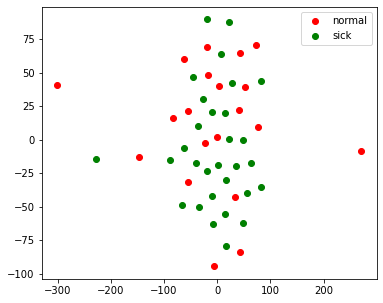

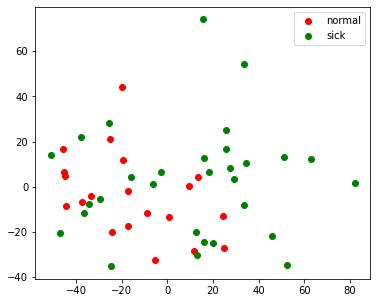

In [29]:
numbers=["normal","sick"]


plt.figure(figsize=(6, 5))
colors = 'r', 'g'
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_2d[Y == i, 0], X_2d[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_untrained_PCA[Y == i, 0], X_untrained_PCA[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()


https://pytorch.org/hub/pytorch_vision_densenet/